# Add Geospatial Data for London

In [1]:
%load_ext autoreload
%autoreload 2

In [65]:
import pandas as pd 
import geopandas as gpd
from glob import glob
from OSGridConverter import latlong2grid
import matplotlib.pyplot as plt 
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame
import seaborn as sns
import altair as alt
import plotly.express as px

## 1. Load Greenspace Data

In [4]:
# read the files 
greenspace1 = gpd.read_file('/Users/florence/Desktop/citizen_science/additional_data/london/open_greenspace/OS Open Greenspace (ESRI Shape File) TQ/data/TQ_GreenspaceSite.shp')
greenspace2 = gpd.read_file('/Users/florence/Desktop/citizen_science/additional_data/london/open_greenspace/OS Open Greenspace (ESRI Shape File) TL/data/TL_GreenspaceSite.shp')
greenspace3 = gpd.read_file('/Users/florence/Desktop/citizen_science/additional_data/london/open_greenspace/OS Open Greenspace (ESRI Shape File) SU/data/SU_GreenspaceSite.shp')
greenspace4 = gpd.read_file('/Users/florence/Desktop/citizen_science/additional_data/london/open_greenspace/OS Open Greenspace (ESRI Shape File) SP/data/SP_GreenspaceSite.shp')

In [5]:
greenspace1.head()

id           function  \
0  AC48C2C9-9043-7B2B-E053-A03BA40AE3D9      Playing Field   
1  AC48C2C9-8EC0-7B2B-E053-A03BA40AE3D9  Religious Grounds   
2  AC48C2DD-1FAE-7B2B-E053-A03BA40AE3D9      Playing Field   
3  AC48C232-76E1-7B2B-E053-A03BA40AE3D9         Play Space   
4  AC48C22F-953B-7B2B-E053-A03BA40AE3D9         Play Space   

            distName1 distName2 distName3 distName4  \
0                None      None      None      None   
1  St Andrew's Church      None      None      None   
2                None      None      None      None   
3                None      None      None      None   
4                None      None      None      None   

                                            geometry  
0  POLYGON Z ((590269.480 194661.750 0.000, 59015...  
1  POLYGON Z ((590884.000 198901.540 0.000, 59088...  
2  POLYGON Z ((590935.250 199521.030 0.000, 59090...  
3  POLYGON Z ((590923.050 199605.960 0.000, 59091...  
4  POLYGON Z ((590961.770 199617.990 0.000, 59095...

In [6]:
# check coordinate reference system
greenspace1.crs

{'init': 'epsg:27700'}

In [7]:
def geometry_to_coords(df):
    df['Center_point'] = df['geometry'].centroid
    #Extract lat and lon from the centerpoint
    df["lat"] = df.Center_point.map(lambda p: p.x)
    df["long"] = df.Center_point.map(lambda p: p.y)

In [8]:
# concatenate all of them 
greenspace = pd.concat([greenspace1, greenspace2, greenspace3, greenspace4])
greenspace.head()

id           function  \
0  AC48C2C9-9043-7B2B-E053-A03BA40AE3D9      Playing Field   
1  AC48C2C9-8EC0-7B2B-E053-A03BA40AE3D9  Religious Grounds   
2  AC48C2DD-1FAE-7B2B-E053-A03BA40AE3D9      Playing Field   
3  AC48C232-76E1-7B2B-E053-A03BA40AE3D9         Play Space   
4  AC48C22F-953B-7B2B-E053-A03BA40AE3D9         Play Space   

            distName1 distName2 distName3 distName4  \
0                None      None      None      None   
1  St Andrew's Church      None      None      None   
2                None      None      None      None   
3                None      None      None      None   
4                None      None      None      None   

                                            geometry  
0  POLYGON Z ((590269.480 194661.750 0.000, 59015...  
1  POLYGON Z ((590884.000 198901.540 0.000, 59088...  
2  POLYGON Z ((590935.250 199521.030 0.000, 59090...  
3  POLYGON Z ((590923.050 199605.960 0.000, 59091...  
4  POLYGON Z ((590961.770 199617.990 0.000, 59095...

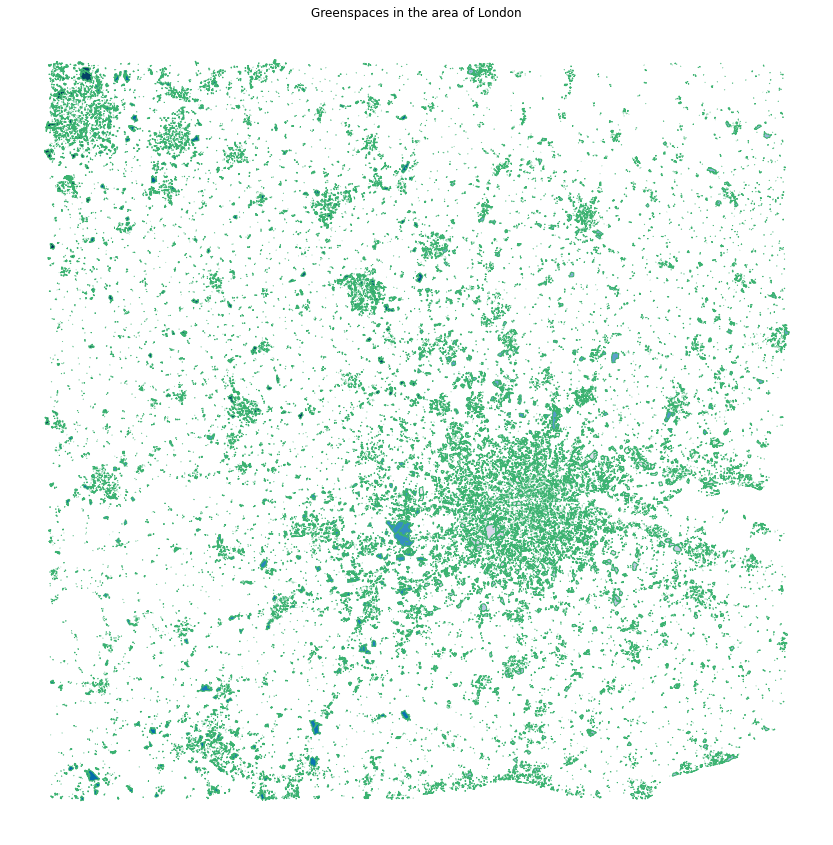

In [9]:
f, ax = plt.subplots(1, figsize=(15, 15))
greenspace.plot(ax=ax, cmap='PuBu', edgecolor='mediumseagreen')
ax.set_axis_off()
plt.title('Greenspaces in the area of London')
plt.show()

## 2. Load iNaturalist data (from London only)

In [10]:
data_folder = '/Users/florence/Desktop/citizen_science/muki_data'
london_df = pd.concat([pd.read_csv(f).assign(challenge=f.replace(".csv","")) for f in glob(data_folder+"/CNC London*.csv")])

In [11]:
london_df.columns

Index(['id', 'observed_on_string', 'observed_on', 'time_observed_at',
       'time_zone', 'user_id', 'user_login', 'created_at', 'updated_at',
       'quality_grade', 'license', 'url', 'image_url', 'sound_url', 'tag_list',
       'description', 'num_identification_agreements',
       'num_identification_disagreements', 'captive_cultivated',
       'oauth_application_id', 'place_guess', 'latitude', 'longitude',
       'positional_accuracy', 'geoprivacy', 'taxon_geoprivacy',
       'coordinates_obscured', 'positioning_method', 'positioning_device',
       'species_guess', 'scientific_name', 'common_name', 'iconic_taxon_name',
       'taxon_id', 'challenge'],
      dtype='object')

In [12]:
london_df[['longitude', 'latitude']].head()

longitude   latitude
0  -0.190717  51.584130
1  -0.192392  51.586492
2  -0.153476  51.630852
3   0.094271  51.612413
4   0.041769  51.664052

### 2.1. Convert Longitude & Latitude to E & N from the OSGrid

In [13]:
es = []
ns = []
for i in range(len(london_df)):
    g=latlong2grid(london_df['latitude'].iloc[i],london_df['longitude'].iloc[i])
    es.append(g.E)
    ns.append(g.N)

In [14]:
london_df['E'] = es
london_df['N'] = ns
london_df.head()

id                         observed_on_string observed_on  \
0  43032927  Fri Apr 24 2020 06:42:48 GMT+0100 (GMT+1)  2020-04-24   
1  43032941  Fri Apr 24 2020 06:36:25 GMT+0100 (GMT+1)  2020-04-24   
2  43033780  Fri Apr 24 2020 07:11:24 GMT+0100 (GMT+1)  2020-04-24   
3  43035672  Fri Apr 24 2020 07:45:17 GMT+0100 (GMT+1)  2020-04-24   
4  43036864            2020-04-24 7:36:12 AM GMT+01:00  2020-04-24   

          time_observed_at  time_zone  user_id    user_login  \
0  2020-04-24 04:42:48 UTC  Amsterdam  2295352  louisebrown1   
1  2020-04-24 04:36:25 UTC  Amsterdam  2295352  louisebrown1   
2  2020-04-24 05:11:24 UTC  Amsterdam  2777317  lynnebennett   
3  2020-04-24 05:45:17 UTC  Amsterdam  1653354      helenfsc   
4  2020-04-24 05:36:12 UTC  Amsterdam  1488476     fsclondon   

                created_at               updated_at quality_grade  ...  \
0  2020-04-24 05:59:08 UTC  2020-04-28 08:44:05 UTC      needs_id  ...   
1  2020-04-24 05:59:36 UTC  2020-05-01 15:01:25 UTC      research  ...   
2  2020-04-24 06:12:40 UTC  2020-04-30 12:47:10 UTC      research  ...   
3  2020-04-24 06:47:58 UTC  2020-04-24 06:48:41 UTC      research  ...   
4  2020-04-24 07:05:13 UTC  2020-05-02 15:38:35 UTC      needs_id  ...   

  positioning_method positioning_device     species_guess  \
0                NaN                NaN   common hawthorn   
1                NaN                NaN           Ramsons   
2                NaN                NaN      carpet bugle   
3                NaN                NaN  Tarassaco comune   
4                gps                gps       Crane Flies   

        scientific_name       common_name iconic_taxon_name  taxon_id  \
0    Crataegus monogyna   common hawthorn           Plantae   51147.0   
1        Allium ursinum           Ramsons           Plantae   56152.0   
2         Ajuga reptans             Bugle           Plantae   56099.0   
3  Taraxacum officinale  common dandelion           Plantae   47602.0   
4          Tipulomorpha       Crane Flies           Insecta  179916.0   

                                           challenge       E       N  
0  /Users/florence/Desktop/citizen_science/muki_d...  525451  188803  
1  /Users/florence/Desktop/citizen_science/muki_d...  525329  189063  
2  /Users/florence/Desktop/citizen_science/muki_d...  527900  194063  
3  /Users/florence/Desktop/citizen_science/muki_d...  545104  192475  
4  /Users/florence/Desktop/citizen_science/muki_d...  541309  198115  

[5 rows x 37 columns]

### 2.2. Add Greenspace-Column to iNaturalist data

In [15]:
geometry = [Point(xy) for xy in zip(london_df.E, london_df.N)]
new_df = london_df.drop(['E', 'N'], axis=1)
gdf = GeoDataFrame(new_df, crs="epsg:27700", geometry=geometry)

In [16]:
gdf.head()

id                         observed_on_string observed_on  \
0  43032927  Fri Apr 24 2020 06:42:48 GMT+0100 (GMT+1)  2020-04-24   
1  43032941  Fri Apr 24 2020 06:36:25 GMT+0100 (GMT+1)  2020-04-24   
2  43033780  Fri Apr 24 2020 07:11:24 GMT+0100 (GMT+1)  2020-04-24   
3  43035672  Fri Apr 24 2020 07:45:17 GMT+0100 (GMT+1)  2020-04-24   
4  43036864            2020-04-24 7:36:12 AM GMT+01:00  2020-04-24   

          time_observed_at  time_zone  user_id    user_login  \
0  2020-04-24 04:42:48 UTC  Amsterdam  2295352  louisebrown1   
1  2020-04-24 04:36:25 UTC  Amsterdam  2295352  louisebrown1   
2  2020-04-24 05:11:24 UTC  Amsterdam  2777317  lynnebennett   
3  2020-04-24 05:45:17 UTC  Amsterdam  1653354      helenfsc   
4  2020-04-24 05:36:12 UTC  Amsterdam  1488476     fsclondon   

                created_at               updated_at quality_grade  ...  \
0  2020-04-24 05:59:08 UTC  2020-04-28 08:44:05 UTC      needs_id  ...   
1  2020-04-24 05:59:36 UTC  2020-05-01 15:01:25 UTC      research  ...   
2  2020-04-24 06:12:40 UTC  2020-04-30 12:47:10 UTC      research  ...   
3  2020-04-24 06:47:58 UTC  2020-04-24 06:48:41 UTC      research  ...   
4  2020-04-24 07:05:13 UTC  2020-05-02 15:38:35 UTC      needs_id  ...   

  coordinates_obscured positioning_method positioning_device  \
0                False                NaN                NaN   
1                False                NaN                NaN   
2                False                NaN                NaN   
3                 True                NaN                NaN   
4                False                gps                gps   

      species_guess       scientific_name       common_name  \
0   common hawthorn    Crataegus monogyna   common hawthorn   
1           Ramsons        Allium ursinum           Ramsons   
2      carpet bugle         Ajuga reptans             Bugle   
3  Tarassaco comune  Taraxacum officinale  common dandelion   
4       Crane Flies          Tipulomorpha       Crane Flies   

   iconic_taxon_name  taxon_id  \
0            Plantae   51147.0   
1            Plantae   56152.0   
2            Plantae   56099.0   
3            Plantae   47602.0   
4            Insecta  179916.0   

                                           challenge  \
0  /Users/florence/Desktop/citizen_science/muki_d...   
1  /Users/florence/Desktop/citizen_science/muki_d...   
2  /Users/florence/Desktop/citizen_science/muki_d...   
3  /Users/florence/Desktop/citizen_science/muki_d...   
4  /Users/florence/Desktop/citizen_science/muki_d...   

                        geometry  
0  POINT (525451.000 188803.000)  
1  POINT (525329.000 189063.000)  
2  POINT (527900.000 194063.000)  
3  POINT (545104.000 192475.000)  
4  POINT (541309.000 198115.000)  

[5 rows x 36 columns]

In [17]:
# join greenspace and London data
points_polys = gpd.sjoin(gdf, greenspace, how="inner") 

/Users/florence/opt/anaconda3/envs/data_analysis/lib/python3.8/site-packages/geopandas/tools/sjoin.py:58: UserWarning: CRS of frames being joined does not match!(epsg:27700 != {'init': 'epsg:27700'})
  warn(


In [18]:
points_polys.columns

Index(['id_left', 'observed_on_string', 'observed_on', 'time_observed_at',
       'time_zone', 'user_id', 'user_login', 'created_at', 'updated_at',
       'quality_grade', 'license', 'url', 'image_url', 'sound_url', 'tag_list',
       'description', 'num_identification_agreements',
       'num_identification_disagreements', 'captive_cultivated',
       'oauth_application_id', 'place_guess', 'latitude', 'longitude',
       'positional_accuracy', 'geoprivacy', 'taxon_geoprivacy',
       'coordinates_obscured', 'positioning_method', 'positioning_device',
       'species_guess', 'scientific_name', 'common_name', 'iconic_taxon_name',
       'taxon_id', 'challenge', 'geometry', 'index_right', 'id_right',
       'function', 'distName1', 'distName2', 'distName3', 'distName4'],
      dtype='object')

In [19]:
points_polys.head()

id_left                         observed_on_string observed_on  \
43  43048184  Fri Apr 24 2020 10:48:01 GMT+0100 (GMT+1)  2020-04-24   
44  43048298  Fri Apr 24 2020 10:49:40 GMT+0100 (GMT+1)  2020-04-24   
46  43048656  Fri Apr 24 2020 10:55:36 GMT+0100 (GMT+1)  2020-04-24   
48  43049097  Fri Apr 24 2020 11:01:56 GMT+0100 (GMT+1)  2020-04-24   
53  43049332  Fri Apr 24 2020 11:05:26 GMT+0100 (GMT+1)  2020-04-24   

           time_observed_at  time_zone  user_id      user_login  \
43  2020-04-24 08:48:01 UTC  Amsterdam  2814937  ethanjackson13   
44  2020-04-24 08:49:40 UTC  Amsterdam  2814937  ethanjackson13   
46  2020-04-24 08:55:36 UTC  Amsterdam  2814937  ethanjackson13   
48  2020-04-24 09:01:56 UTC  Amsterdam  2814937  ethanjackson13   
53  2020-04-24 09:05:26 UTC  Amsterdam  2814937  ethanjackson13   

                 created_at               updated_at quality_grade  ...  \
43  2020-04-24 09:48:28 UTC  2020-04-28 08:50:05 UTC        casual  ...   
44  2020-04-24 09:50:06 UTC  2020-04-28 08:50:42 UTC        casual  ...   
46  2020-04-24 09:55:51 UTC  2020-04-24 09:56:00 UTC      needs_id  ...   
48  2020-04-24 10:02:26 UTC  2020-04-24 11:42:18 UTC      research  ...   
53  2020-04-24 10:05:36 UTC  2020-04-24 10:06:17 UTC        casual  ...   

    taxon_id                                          challenge  \
43   47407.0  /Users/florence/Desktop/citizen_science/muki_d...   
44   51267.0  /Users/florence/Desktop/citizen_science/muki_d...   
46   53350.0  /Users/florence/Desktop/citizen_science/muki_d...   
48  464103.0  /Users/florence/Desktop/citizen_science/muki_d...   
53   47374.0  /Users/florence/Desktop/citizen_science/muki_d...   

                         geometry index_right  \
43  POINT (529617.000 193689.000)        1298   
44  POINT (529693.000 193700.000)        1298   
46  POINT (529674.000 193576.000)        1298   
48  POINT (529617.000 193446.000)        1298   
53  POINT (529500.000 193524.000)        1298   

                                id_right       function  \
43  AC48C27B-2DFA-7B2B-E053-A03BA40AE3D9  Playing Field   
44  AC48C27B-2DFA-7B2B-E053-A03BA40AE3D9  Playing Field   
46  AC48C27B-2DFA-7B2B-E053-A03BA40AE3D9  Playing Field   
48  AC48C27B-2DFA-7B2B-E053-A03BA40AE3D9  Playing Field   
53  AC48C27B-2DFA-7B2B-E053-A03BA40AE3D9  Playing Field   

                    distName1  distName2  distName3  distName4  
43  The Walker Cricket Ground       None       None       None  
44  The Walker Cricket Ground       None       None       None  
46  The Walker Cricket Ground       None       None       None  
48  The Walker Cricket Ground       None       None       None  
53  The Walker Cricket Ground       None       None       None  

[5 rows x 43 columns]

In [20]:
ids_with_greenspace = points_polys.id_left.to_list()

In [21]:
# set Flag for greenspace in the iNaturalist DataFrame 
new_london = london_df.set_index('id')
new_london.head()

observed_on_string observed_on  \
id                                                                
43032927  Fri Apr 24 2020 06:42:48 GMT+0100 (GMT+1)  2020-04-24   
43032941  Fri Apr 24 2020 06:36:25 GMT+0100 (GMT+1)  2020-04-24   
43033780  Fri Apr 24 2020 07:11:24 GMT+0100 (GMT+1)  2020-04-24   
43035672  Fri Apr 24 2020 07:45:17 GMT+0100 (GMT+1)  2020-04-24   
43036864            2020-04-24 7:36:12 AM GMT+01:00  2020-04-24   

                 time_observed_at  time_zone  user_id    user_login  \
id                                                                    
43032927  2020-04-24 04:42:48 UTC  Amsterdam  2295352  louisebrown1   
43032941  2020-04-24 04:36:25 UTC  Amsterdam  2295352  louisebrown1   
43033780  2020-04-24 05:11:24 UTC  Amsterdam  2777317  lynnebennett   
43035672  2020-04-24 05:45:17 UTC  Amsterdam  1653354      helenfsc   
43036864  2020-04-24 05:36:12 UTC  Amsterdam  1488476     fsclondon   

                       created_at               updated_at quality_grade  \
id                                                                         
43032927  2020-04-24 05:59:08 UTC  2020-04-28 08:44:05 UTC      needs_id   
43032941  2020-04-24 05:59:36 UTC  2020-05-01 15:01:25 UTC      research   
43033780  2020-04-24 06:12:40 UTC  2020-04-30 12:47:10 UTC      research   
43035672  2020-04-24 06:47:58 UTC  2020-04-24 06:48:41 UTC      research   
43036864  2020-04-24 07:05:13 UTC  2020-05-02 15:38:35 UTC      needs_id   

           license  ... positioning_method positioning_device  \
id                  ...                                         
43032927       NaN  ...                NaN                NaN   
43032941       NaN  ...                NaN                NaN   
43033780  CC-BY-NC  ...                NaN                NaN   
43035672  CC-BY-NC  ...                NaN                NaN   
43036864  CC-BY-NC  ...                gps                gps   

             species_guess       scientific_name       common_name  \
id                                                                   
43032927   common hawthorn    Crataegus monogyna   common hawthorn   
43032941           Ramsons        Allium ursinum           Ramsons   
43033780      carpet bugle         Ajuga reptans             Bugle   
43035672  Tarassaco comune  Taraxacum officinale  common dandelion   
43036864       Crane Flies          Tipulomorpha       Crane Flies   

          iconic_taxon_name  taxon_id  \
id                                      
43032927            Plantae   51147.0   
43032941            Plantae   56152.0   
43033780            Plantae   56099.0   
43035672            Plantae   47602.0   
43036864            Insecta  179916.0   

                                                  challenge       E       N  
id                                                                           
43032927  /Users/florence/Desktop/citizen_science/muki_d...  525451  188803  
43032941  /Users/florence/Desktop/citizen_science/muki_d...  525329  189063  
43033780  /Users/florence/Desktop/citizen_science/muki_d...  527900  194063  
43035672  /Users/florence/Desktop/citizen_science/muki_d...  545104  192475  
43036864  /Users/florence/Desktop/citizen_science/muki_d...  541309  198115  

[5 rows x 36 columns]

In [22]:
new_london['greenspace_flag'] = '0'
new_london.loc[ids_with_greenspace,'greenspace_flag'] = '1'

In [23]:
new_london.head()

observed_on_string observed_on  \
id                                                                
43032927  Fri Apr 24 2020 06:42:48 GMT+0100 (GMT+1)  2020-04-24   
43032941  Fri Apr 24 2020 06:36:25 GMT+0100 (GMT+1)  2020-04-24   
43033780  Fri Apr 24 2020 07:11:24 GMT+0100 (GMT+1)  2020-04-24   
43035672  Fri Apr 24 2020 07:45:17 GMT+0100 (GMT+1)  2020-04-24   
43036864            2020-04-24 7:36:12 AM GMT+01:00  2020-04-24   

                 time_observed_at  time_zone  user_id    user_login  \
id                                                                    
43032927  2020-04-24 04:42:48 UTC  Amsterdam  2295352  louisebrown1   
43032941  2020-04-24 04:36:25 UTC  Amsterdam  2295352  louisebrown1   
43033780  2020-04-24 05:11:24 UTC  Amsterdam  2777317  lynnebennett   
43035672  2020-04-24 05:45:17 UTC  Amsterdam  1653354      helenfsc   
43036864  2020-04-24 05:36:12 UTC  Amsterdam  1488476     fsclondon   

                       created_at               updated_at quality_grade  \
id                                                                         
43032927  2020-04-24 05:59:08 UTC  2020-04-28 08:44:05 UTC      needs_id   
43032941  2020-04-24 05:59:36 UTC  2020-05-01 15:01:25 UTC      research   
43033780  2020-04-24 06:12:40 UTC  2020-04-30 12:47:10 UTC      research   
43035672  2020-04-24 06:47:58 UTC  2020-04-24 06:48:41 UTC      research   
43036864  2020-04-24 07:05:13 UTC  2020-05-02 15:38:35 UTC      needs_id   

           license  ... positioning_device     species_guess  \
id                  ...                                        
43032927       NaN  ...                NaN   common hawthorn   
43032941       NaN  ...                NaN           Ramsons   
43033780  CC-BY-NC  ...                NaN      carpet bugle   
43035672  CC-BY-NC  ...                NaN  Tarassaco comune   
43036864  CC-BY-NC  ...                gps       Crane Flies   

               scientific_name       common_name iconic_taxon_name  taxon_id  \
id                                                                             
43032927    Crataegus monogyna   common hawthorn           Plantae   51147.0   
43032941        Allium ursinum           Ramsons           Plantae   56152.0   
43033780         Ajuga reptans             Bugle           Plantae   56099.0   
43035672  Taraxacum officinale  common dandelion           Plantae   47602.0   
43036864          Tipulomorpha       Crane Flies           Insecta  179916.0   

                                                  challenge       E       N  \
id                                                                            
43032927  /Users/florence/Desktop/citizen_science/muki_d...  525451  188803   
43032941  /Users/florence/Desktop/citizen_science/muki_d...  525329  189063   
43033780  /Users/florence/Desktop/citizen_science/muki_d...  527900  194063   
43035672  /Users/florence/Desktop/citizen_science/muki_d...  545104  192475   
43036864  /Users/florence/Desktop/citizen_science/muki_d...  541309  198115   

         greenspace_flag  
id                        
43032927               0  
43032941               0  
43033780               0  
43035672               0  
43036864               0  

[5 rows x 37 columns]

In [24]:
new_london.greenspace_flag.value_counts()

0    8235
1    5495
Name: greenspace_flag, dtype: int64

### 2.3. Calculate distances from observation points to greenspace polygons

Calculate the minimum distance from an observation-point to a greenspace-polygon (how far is the location of the observation away from the next greenspace?):

In [25]:
def min_distance(point, lines):
    return lines.distance(point).min()

if False:
    gdf['min_dist_to_greenspace'] = gdf.geometry.apply(min_distance, args=(greenspace.geometry,))

## 3. Read Bluespace-Shapefiles

In [26]:
bluespace = gpd.read_file('/Users/florence/Desktop/citizen_science/additional_data/london/open_bluespace/data/WatercourseLink.shp')

In [27]:
bluespace.head()

name1                            identifier  \
0     Burn of Skaw  65587873-6B4A-49A0-9000-20CC7D38C033   
1  Burn of Norwick  2D0AB017-BA69-40A6-9DF2-43FF5A81BEED   
2             None  643C587F-D1EF-438D-B520-7C0F405EA896   
3             None  8CA995C7-FFC6-4E2A-AB16-B16C318C2EA1   
4  Burn of Norwick  79A8711A-05A9-4C1D-B011-F05A8E410C97   

                              startNode                               endNode  \
0  3C4DB5F6-FF49-4379-9BED-1C96D4FD7D96  630A2DCB-C0B1-49CD-9C08-F24AB6735F71   
1  E6B7CA22-58B6-4936-B419-1D1F07E19D6F  B9E9254B-AE8C-4457-9C8C-904D8662AA43   
2  6AABC603-5B84-4BFC-8BCC-06D243219996  B9E9254B-AE8C-4457-9C8C-904D8662AA43   
3  BF6A5053-7DC6-4735-8206-072A271BB188  236B5EFF-F0DD-4607-9747-B953F7A2A129   
4  B9E9254B-AE8C-4457-9C8C-904D8662AA43  236B5EFF-F0DD-4607-9747-B953F7A2A129   

          form          flow fictitious  length name2  \
0  inlandRiver  in direction      false    1696  None   
1  inlandRiver  in direction      false     559  None   
2  inlandRiver  in direction      false      96  None   
3  inlandRiver  in direction      false     317  None   
4  inlandRiver  in direction      false      49  None   

                                            geometry  
0  LINESTRING Z (464604.980 1216285.950 0.000, 46...  
1  LINESTRING Z (464632.760 1214060.700 0.000, 46...  
2  LINESTRING Z (464782.250 1214486.580 0.000, 46...  
3  LINESTRING Z (464897.380 1214802.590 0.000, 46...  
4  LINESTRING Z (464876.250 1214469.160 0.000, 46...

In [28]:
bluespace.geometry

0         LINESTRING Z (464604.980 1216285.950 0.000, 46...
1         LINESTRING Z (464632.760 1214060.700 0.000, 46...
2         LINESTRING Z (464782.250 1214486.580 0.000, 46...
3         LINESTRING Z (464897.380 1214802.590 0.000, 46...
4         LINESTRING Z (464876.250 1214469.160 0.000, 46...
                                ...                        
186250    LINESTRING Z (142067.430 33538.460 0.000, 1420...
186251    LINESTRING Z (142461.010 34188.040 0.000, 1423...
186252    LINESTRING Z (145424.720 35748.270 0.000, 1454...
186253    LINESTRING Z (139378.670 35449.550 0.000, 1393...
186254    LINESTRING Z (143070.370 37026.090 0.000, 1430...
Name: geometry, Length: 186255, dtype: geometry

In [29]:
bluespace.crs

{'init': 'epsg:27700'}

In [30]:
greenspace.crs

{'init': 'epsg:27700'}

In [31]:
bluespace_points = gpd.sjoin(gdf, bluespace, how="inner") 

/Users/florence/opt/anaconda3/envs/data_analysis/lib/python3.8/site-packages/geopandas/tools/sjoin.py:58: UserWarning: CRS of frames being joined does not match!(epsg:27700 != {'init': 'epsg:27700'})
  warn(


Do the same distance calculation for the bluespace data as we did for the greenspace data in order to check how far the next bluespace is from the observation location:

In [32]:
if False: 
    gdf['min_dist_to_bluespace'] = gdf.geometry.apply(min_distance, args=(bluespace.geometry,))

In [33]:
if False: 
    gdf.to_csv('/Users/florence/Desktop/citizen_science/joined_data.csv')

## 4. Load newly created DataFrame

In [34]:
joined_data = pd.read_csv('/Users/florence/Desktop/citizen_science/joined_data.csv', index_col=0)

In [35]:
joined_data.head()

id                         observed_on_string observed_on  \
0  43032927  Fri Apr 24 2020 06:42:48 GMT+0100 (GMT+1)  2020-04-24   
1  43032941  Fri Apr 24 2020 06:36:25 GMT+0100 (GMT+1)  2020-04-24   
2  43033780  Fri Apr 24 2020 07:11:24 GMT+0100 (GMT+1)  2020-04-24   
3  43035672  Fri Apr 24 2020 07:45:17 GMT+0100 (GMT+1)  2020-04-24   
4  43036864            2020-04-24 7:36:12 AM GMT+01:00  2020-04-24   

          time_observed_at  time_zone  user_id    user_login  \
0  2020-04-24 04:42:48 UTC  Amsterdam  2295352  louisebrown1   
1  2020-04-24 04:36:25 UTC  Amsterdam  2295352  louisebrown1   
2  2020-04-24 05:11:24 UTC  Amsterdam  2777317  lynnebennett   
3  2020-04-24 05:45:17 UTC  Amsterdam  1653354      helenfsc   
4  2020-04-24 05:36:12 UTC  Amsterdam  1488476     fsclondon   

                created_at               updated_at quality_grade  ...  \
0  2020-04-24 05:59:08 UTC  2020-04-28 08:44:05 UTC      needs_id  ...   
1  2020-04-24 05:59:36 UTC  2020-05-01 15:01:25 UTC      research  ...   
2  2020-04-24 06:12:40 UTC  2020-04-30 12:47:10 UTC      research  ...   
3  2020-04-24 06:47:58 UTC  2020-04-24 06:48:41 UTC      research  ...   
4  2020-04-24 07:05:13 UTC  2020-05-02 15:38:35 UTC      needs_id  ...   

  positioning_device     species_guess       scientific_name  \
0                NaN   common hawthorn    Crataegus monogyna   
1                NaN           Ramsons        Allium ursinum   
2                NaN      carpet bugle         Ajuga reptans   
3                NaN  Tarassaco comune  Taraxacum officinale   
4                gps       Crane Flies          Tipulomorpha   

        common_name iconic_taxon_name  taxon_id  \
0   common hawthorn           Plantae   51147.0   
1           Ramsons           Plantae   56152.0   
2             Bugle           Plantae   56099.0   
3  common dandelion           Plantae   47602.0   
4       Crane Flies           Insecta  179916.0   

                                           challenge               geometry  \
0  /Users/florence/Desktop/citizen_science/muki_d...  POINT (525451 188803)   
1  /Users/florence/Desktop/citizen_science/muki_d...  POINT (525329 189063)   
2  /Users/florence/Desktop/citizen_science/muki_d...  POINT (527900 194063)   
3  /Users/florence/Desktop/citizen_science/muki_d...  POINT (545104 192475)   
4  /Users/florence/Desktop/citizen_science/muki_d...  POINT (541309 198115)   

   min_dist_to_greenspace  min_dist_to_bluespace  
0               69.467690            1442.099763  
1               96.135321            1276.338777  
2              373.548725             496.550008  
3              117.303361             819.395954  
4              548.408789             654.755189  

[5 rows x 38 columns]

In [36]:
# set Flag for greenspace in the iNaturalist DataFrame 
new_joined = joined_data.set_index('id')
new_joined.head()

observed_on_string observed_on  \
id                                                                
43032927  Fri Apr 24 2020 06:42:48 GMT+0100 (GMT+1)  2020-04-24   
43032941  Fri Apr 24 2020 06:36:25 GMT+0100 (GMT+1)  2020-04-24   
43033780  Fri Apr 24 2020 07:11:24 GMT+0100 (GMT+1)  2020-04-24   
43035672  Fri Apr 24 2020 07:45:17 GMT+0100 (GMT+1)  2020-04-24   
43036864            2020-04-24 7:36:12 AM GMT+01:00  2020-04-24   

                 time_observed_at  time_zone  user_id    user_login  \
id                                                                    
43032927  2020-04-24 04:42:48 UTC  Amsterdam  2295352  louisebrown1   
43032941  2020-04-24 04:36:25 UTC  Amsterdam  2295352  louisebrown1   
43033780  2020-04-24 05:11:24 UTC  Amsterdam  2777317  lynnebennett   
43035672  2020-04-24 05:45:17 UTC  Amsterdam  1653354      helenfsc   
43036864  2020-04-24 05:36:12 UTC  Amsterdam  1488476     fsclondon   

                       created_at               updated_at quality_grade  \
id                                                                         
43032927  2020-04-24 05:59:08 UTC  2020-04-28 08:44:05 UTC      needs_id   
43032941  2020-04-24 05:59:36 UTC  2020-05-01 15:01:25 UTC      research   
43033780  2020-04-24 06:12:40 UTC  2020-04-30 12:47:10 UTC      research   
43035672  2020-04-24 06:47:58 UTC  2020-04-24 06:48:41 UTC      research   
43036864  2020-04-24 07:05:13 UTC  2020-05-02 15:38:35 UTC      needs_id   

           license  ... positioning_device     species_guess  \
id                  ...                                        
43032927       NaN  ...                NaN   common hawthorn   
43032941       NaN  ...                NaN           Ramsons   
43033780  CC-BY-NC  ...                NaN      carpet bugle   
43035672  CC-BY-NC  ...                NaN  Tarassaco comune   
43036864  CC-BY-NC  ...                gps       Crane Flies   

               scientific_name       common_name iconic_taxon_name  taxon_id  \
id                                                                             
43032927    Crataegus monogyna   common hawthorn           Plantae   51147.0   
43032941        Allium ursinum           Ramsons           Plantae   56152.0   
43033780         Ajuga reptans             Bugle           Plantae   56099.0   
43035672  Taraxacum officinale  common dandelion           Plantae   47602.0   
43036864          Tipulomorpha       Crane Flies           Insecta  179916.0   

                                                  challenge  \
id                                                            
43032927  /Users/florence/Desktop/citizen_science/muki_d...   
43032941  /Users/florence/Desktop/citizen_science/muki_d...   
43033780  /Users/florence/Desktop/citizen_science/muki_d...   
43035672  /Users/florence/Desktop/citizen_science/muki_d...   
43036864  /Users/florence/Desktop/citizen_science/muki_d...   

                       geometry  min_dist_to_greenspace min_dist_to_bluespace  
id                                                                             
43032927  POINT (525451 188803)               69.467690           1442.099763  
43032941  POINT (525329 189063)               96.135321           1276.338777  
43033780  POINT (527900 194063)              373.548725            496.550008  
43035672  POINT (545104 192475)              117.303361            819.395954  
43036864  POINT (541309 198115)              548.408789            654.755189  

[5 rows x 37 columns]

In [37]:
new_joined['greenspace_flag'] = '0'
new_joined.loc[ids_with_greenspace,'greenspace_flag'] = '1'

In [38]:
new_joined.greenspace_flag.value_counts()

0    8235
1    5495
Name: greenspace_flag, dtype: int64

In [39]:
new_joined['min_dist_to_bluespace'] = new_joined['min_dist_to_bluespace']/1000.0 # to get distance in km and not meters

In [40]:
new_joined['min_dist_to_greenspace'] = new_joined['min_dist_to_greenspace']/1000.0

In [41]:
new_joined.head()

observed_on_string observed_on  \
id                                                                
43032927  Fri Apr 24 2020 06:42:48 GMT+0100 (GMT+1)  2020-04-24   
43032941  Fri Apr 24 2020 06:36:25 GMT+0100 (GMT+1)  2020-04-24   
43033780  Fri Apr 24 2020 07:11:24 GMT+0100 (GMT+1)  2020-04-24   
43035672  Fri Apr 24 2020 07:45:17 GMT+0100 (GMT+1)  2020-04-24   
43036864            2020-04-24 7:36:12 AM GMT+01:00  2020-04-24   

                 time_observed_at  time_zone  user_id    user_login  \
id                                                                    
43032927  2020-04-24 04:42:48 UTC  Amsterdam  2295352  louisebrown1   
43032941  2020-04-24 04:36:25 UTC  Amsterdam  2295352  louisebrown1   
43033780  2020-04-24 05:11:24 UTC  Amsterdam  2777317  lynnebennett   
43035672  2020-04-24 05:45:17 UTC  Amsterdam  1653354      helenfsc   
43036864  2020-04-24 05:36:12 UTC  Amsterdam  1488476     fsclondon   

                       created_at               updated_at quality_grade  \
id                                                                         
43032927  2020-04-24 05:59:08 UTC  2020-04-28 08:44:05 UTC      needs_id   
43032941  2020-04-24 05:59:36 UTC  2020-05-01 15:01:25 UTC      research   
43033780  2020-04-24 06:12:40 UTC  2020-04-30 12:47:10 UTC      research   
43035672  2020-04-24 06:47:58 UTC  2020-04-24 06:48:41 UTC      research   
43036864  2020-04-24 07:05:13 UTC  2020-05-02 15:38:35 UTC      needs_id   

           license  ...     species_guess       scientific_name  \
id                  ...                                           
43032927       NaN  ...   common hawthorn    Crataegus monogyna   
43032941       NaN  ...           Ramsons        Allium ursinum   
43033780  CC-BY-NC  ...      carpet bugle         Ajuga reptans   
43035672  CC-BY-NC  ...  Tarassaco comune  Taraxacum officinale   
43036864  CC-BY-NC  ...       Crane Flies          Tipulomorpha   

               common_name iconic_taxon_name  taxon_id  \
id                                                       
43032927   common hawthorn           Plantae   51147.0   
43032941           Ramsons           Plantae   56152.0   
43033780             Bugle           Plantae   56099.0   
43035672  common dandelion           Plantae   47602.0   
43036864       Crane Flies           Insecta  179916.0   

                                                  challenge  \
id                                                            
43032927  /Users/florence/Desktop/citizen_science/muki_d...   
43032941  /Users/florence/Desktop/citizen_science/muki_d...   
43033780  /Users/florence/Desktop/citizen_science/muki_d...   
43035672  /Users/florence/Desktop/citizen_science/muki_d...   
43036864  /Users/florence/Desktop/citizen_science/muki_d...   

                       geometry  min_dist_to_greenspace  \
id                                                        
43032927  POINT (525451 188803)                0.069468   
43032941  POINT (525329 189063)                0.096135   
43033780  POINT (527900 194063)                0.373549   
43035672  POINT (545104 192475)                0.117303   
43036864  POINT (541309 198115)                0.548409   

          min_dist_to_bluespace greenspace_flag  
id                                               
43032927               1.442100               0  
43032941               1.276339               0  
43033780               0.496550               0  
43035672               0.819396               0  
43036864               0.654755               0  

[5 rows x 38 columns]

## 5. Group new DataFrame by users and check correlation between number of observations and distance from greenspace/bluespace

In [42]:
grouped_users = new_joined.groupby('user_id').quality_grade.count()
grouped_users = grouped_users.to_frame()
grouped_users.rename(columns={'quality_grade':'num_obs'}, inplace=True)
grouped_users.head()

num_obs
user_id         
484           15
1245           2
1439           2
2111           2
13244          3

In [43]:
# get mean distance to greenspace for each user
grouped_greenspace = new_joined.groupby('user_id').min_dist_to_greenspace.mean()
grouped_greenspace = grouped_greenspace.to_frame()
grouped_greenspace.rename(columns={'min_dist_to_greenspace':'mean_green_dist'}, inplace=True)
grouped_greenspace.head()

mean_green_dist
user_id                 
484             0.084203
1245            0.070517
1439            0.139881
2111            0.567320
13244           0.412155

In [44]:
# get mean distance to greenspace for each user
grouped_bluespace = new_joined.groupby('user_id').min_dist_to_bluespace.mean()
grouped_bluespace = grouped_bluespace.to_frame()
grouped_bluespace.rename(columns={'min_dist_to_bluespace':'mean_blue_dist'}, inplace=True)
grouped_bluespace.head()

mean_blue_dist
user_id                
484            0.178463
1245           0.803926
1439           0.245318
2111           0.684608
13244          0.973430

In [45]:
joined_df = pd.concat([grouped_users, grouped_greenspace, grouped_bluespace], axis=1)

In [46]:
joined_df.head()

num_obs  mean_green_dist  mean_blue_dist
user_id                                          
484           15         0.084203        0.178463
1245           2         0.070517        0.803926
1439           2         0.139881        0.245318
2111           2         0.567320        0.684608
13244          3         0.412155        0.973430

<AxesSubplot:>

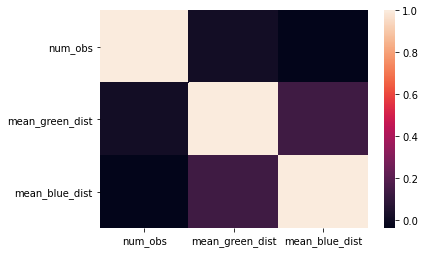

In [47]:
corr = joined_df.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [48]:
new_joined.columns

Index(['observed_on_string', 'observed_on', 'time_observed_at', 'time_zone',
       'user_id', 'user_login', 'created_at', 'updated_at', 'quality_grade',
       'license', 'url', 'image_url', 'sound_url', 'tag_list', 'description',
       'num_identification_agreements', 'num_identification_disagreements',
       'captive_cultivated', 'oauth_application_id', 'place_guess', 'latitude',
       'longitude', 'positional_accuracy', 'geoprivacy', 'taxon_geoprivacy',
       'coordinates_obscured', 'positioning_method', 'positioning_device',
       'species_guess', 'scientific_name', 'common_name', 'iconic_taxon_name',
       'taxon_id', 'challenge', 'geometry', 'min_dist_to_greenspace',
       'min_dist_to_bluespace', 'greenspace_flag'],
      dtype='object')

In [51]:
len(new_joined.taxon_id.unique())

2462

In [52]:
new_joined.iconic_taxon_name.unique()

array(['Plantae', 'Insecta', 'Aves', 'Mammalia', 'Arachnida', nan,
       'Mollusca', 'Fungi', 'Animalia', 'Amphibia', 'Actinopterygii',
       'Protozoa', 'Reptilia'], dtype=object)

In [ ]:
## correlation für kategorische Features checken 

## 6. Plot Observations by `iconic_taxon_name`

In [60]:
new_joined.time_observed_at = pd.to_datetime(new_joined.time_observed_at)
new_joined.observed_on = pd.to_datetime(new_joined.observed_on)
new_joined.created_at = pd.to_datetime(new_joined.created_at)
new_joined.updated_at = pd.to_datetime(new_joined.updated_at)

In [61]:
new_joined.time_observed_at.min()

Timestamp('2018-04-27 06:34:31+0000', tz='UTC')

In [62]:
new_joined.time_observed_at.max()

Timestamp('2020-04-27 22:17:07+0000', tz='UTC')

In [63]:
new_joined.head()

observed_on_string observed_on  \
id                                                                
43032927  Fri Apr 24 2020 06:42:48 GMT+0100 (GMT+1)  2020-04-24   
43032941  Fri Apr 24 2020 06:36:25 GMT+0100 (GMT+1)  2020-04-24   
43033780  Fri Apr 24 2020 07:11:24 GMT+0100 (GMT+1)  2020-04-24   
43035672  Fri Apr 24 2020 07:45:17 GMT+0100 (GMT+1)  2020-04-24   
43036864            2020-04-24 7:36:12 AM GMT+01:00  2020-04-24   

                  time_observed_at  time_zone  user_id    user_login  \
id                                                                     
43032927 2020-04-24 04:42:48+00:00  Amsterdam  2295352  louisebrown1   
43032941 2020-04-24 04:36:25+00:00  Amsterdam  2295352  louisebrown1   
43033780 2020-04-24 05:11:24+00:00  Amsterdam  2777317  lynnebennett   
43035672 2020-04-24 05:45:17+00:00  Amsterdam  1653354      helenfsc   
43036864 2020-04-24 05:36:12+00:00  Amsterdam  1488476     fsclondon   

                        created_at                updated_at quality_grade  \
id                                                                           
43032927 2020-04-24 05:59:08+00:00 2020-04-28 08:44:05+00:00      needs_id   
43032941 2020-04-24 05:59:36+00:00 2020-05-01 15:01:25+00:00      research   
43033780 2020-04-24 06:12:40+00:00 2020-04-30 12:47:10+00:00      research   
43035672 2020-04-24 06:47:58+00:00 2020-04-24 06:48:41+00:00      research   
43036864 2020-04-24 07:05:13+00:00 2020-05-02 15:38:35+00:00      needs_id   

           license  ...     species_guess       scientific_name  \
id                  ...                                           
43032927       NaN  ...   common hawthorn    Crataegus monogyna   
43032941       NaN  ...           Ramsons        Allium ursinum   
43033780  CC-BY-NC  ...      carpet bugle         Ajuga reptans   
43035672  CC-BY-NC  ...  Tarassaco comune  Taraxacum officinale   
43036864  CC-BY-NC  ...       Crane Flies          Tipulomorpha   

               common_name iconic_taxon_name  taxon_id  \
id                                                       
43032927   common hawthorn           Plantae   51147.0   
43032941           Ramsons           Plantae   56152.0   
43033780             Bugle           Plantae   56099.0   
43035672  common dandelion           Plantae   47602.0   
43036864       Crane Flies           Insecta  179916.0   

                                                  challenge  \
id                                                            
43032927  /Users/florence/Desktop/citizen_science/muki_d...   
43032941  /Users/florence/Desktop/citizen_science/muki_d...   
43033780  /Users/florence/Desktop/citizen_science/muki_d...   
43035672  /Users/florence/Desktop/citizen_science/muki_d...   
43036864  /Users/florence/Desktop/citizen_science/muki_d...   

                       geometry  min_dist_to_greenspace  \
id                                                        
43032927  POINT (525451 188803)                0.069468   
43032941  POINT (525329 189063)                0.096135   
43033780  POINT (527900 194063)                0.373549   
43035672  POINT (545104 192475)                0.117303   
43036864  POINT (541309 198115)                0.548409   

          min_dist_to_bluespace greenspace_flag  
id                                               
43032927               1.442100               0  
43032941               1.276339               0  
43033780               0.496550               0  
43035672               0.819396               0  
43036864               0.654755               0  

[5 rows x 38 columns]

In [64]:
new_joined.columns

Index(['observed_on_string', 'observed_on', 'time_observed_at', 'time_zone',
       'user_id', 'user_login', 'created_at', 'updated_at', 'quality_grade',
       'license', 'url', 'image_url', 'sound_url', 'tag_list', 'description',
       'num_identification_agreements', 'num_identification_disagreements',
       'captive_cultivated', 'oauth_application_id', 'place_guess', 'latitude',
       'longitude', 'positional_accuracy', 'geoprivacy', 'taxon_geoprivacy',
       'coordinates_obscured', 'positioning_method', 'positioning_device',
       'species_guess', 'scientific_name', 'common_name', 'iconic_taxon_name',
       'taxon_id', 'challenge', 'geometry', 'min_dist_to_greenspace',
       'min_dist_to_bluespace', 'greenspace_flag'],
      dtype='object')

### 6.1. all three years

In [74]:
new_joined['year'] = 0

In [97]:
new_joined.set_index('observed_on', inplace=True)

In [81]:
new_joined.loc[(new_joined.index.year.isin([2018])), 'year'] = 2018
new_joined.loc[(new_joined.index.year.isin([2019])), 'year'] = 2019
new_joined.loc[(new_joined.index.year.isin([2020])), 'year'] = 2020

In [83]:
new_joined.dropna(subset=['iconic_taxon_name'], inplace=True)

In [85]:
new_joined.sort_values(by=['year'], inplace=True)

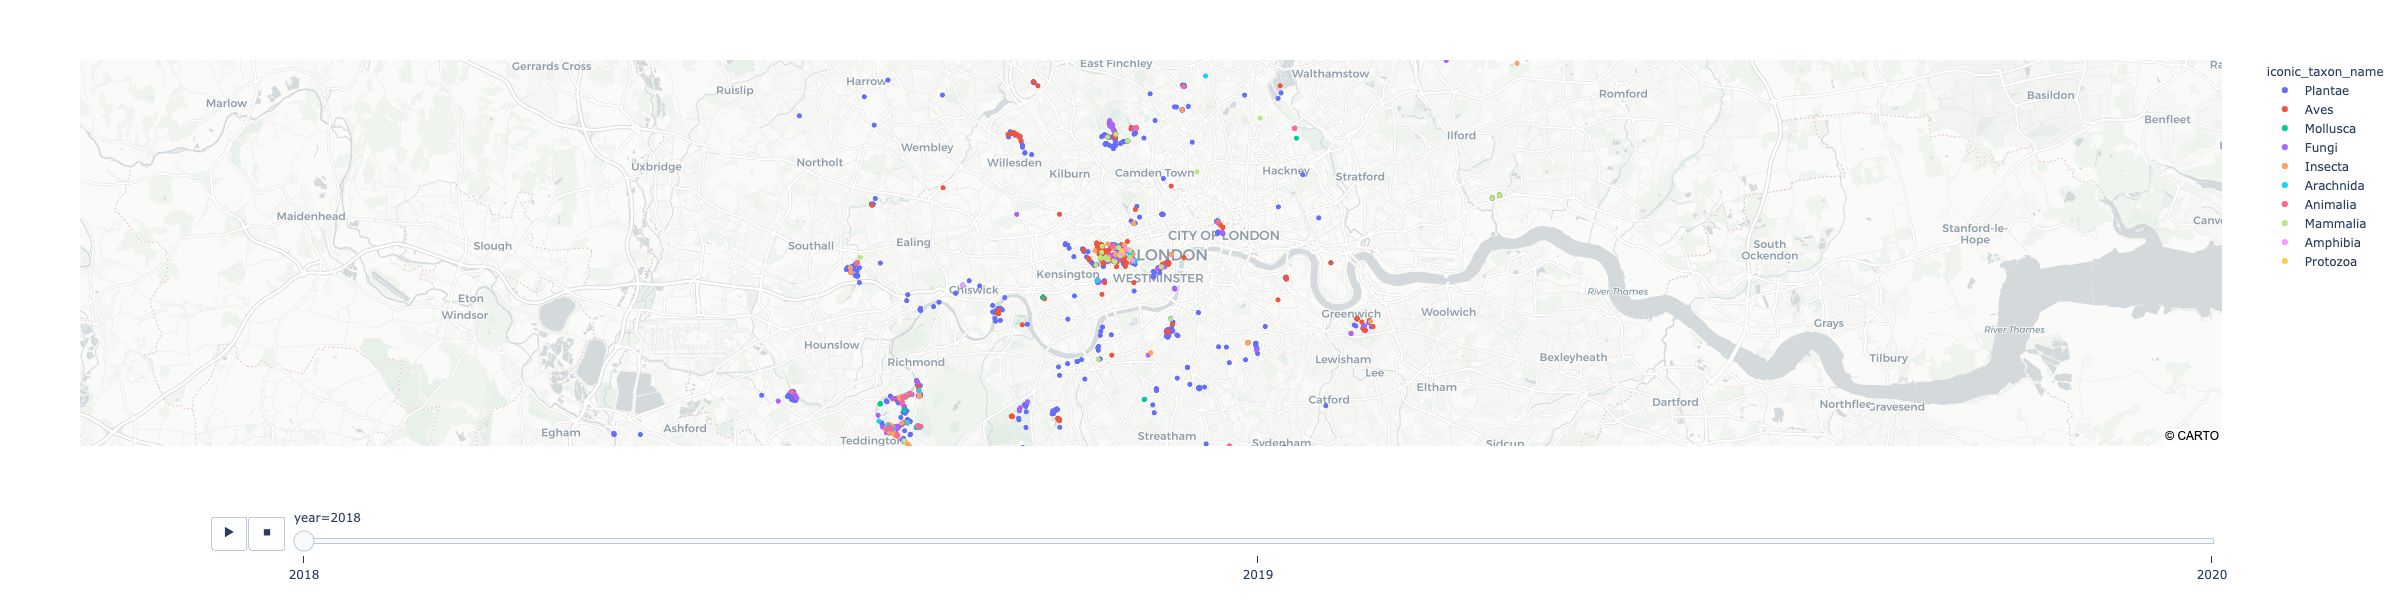

In [86]:
fig = px.scatter_mapbox(new_joined, lat="latitude", lon="longitude", zoom=10, color='iconic_taxon_name', mapbox_style="carto-positron", animation_frame='year', height=600, hover_name='common_name')
fig.show()

## 7. Clustering Data with K-Means

### 7.1. Elbow Curve first:

In [87]:
from sklearn.cluster import KMeans

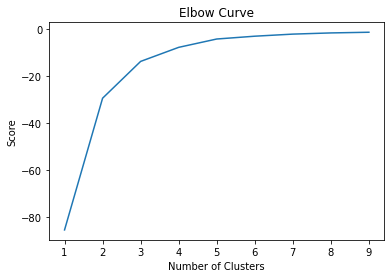

In [88]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = new_joined[['latitude']]
X_axis = new_joined[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

4 Clusters seem to be a good choice.

In [91]:
X=new_joined.loc[:,['iconic_taxon_name','latitude','longitude', 'year', 'common_name']]

In [95]:
kmeans = KMeans(n_clusters = 8, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(10)

iconic_taxon_name   latitude  longitude  year  \
observed_on                                                 
2018-04-29            Plantae  51.509067  -0.188106  2018   
2018-04-28            Plantae  51.506382  -0.194776  2018   
2018-04-28               Aves  51.445555  -0.317675  2018   
2018-04-28               Aves  51.560953  -0.155585  2018   
2018-04-28               Aves  51.435508  -0.309758  2018   
2018-04-28               Aves  51.561589  -0.155377  2018   
2018-04-28            Plantae  51.435825  -0.307158  2018   
2018-04-28               Aves  51.435537  -0.309505  2018   
2018-04-28           Mollusca  51.443413  -0.327928  2018   
2018-04-28            Plantae  51.435950  -0.307292  2018   

                           common_name  cluster_label  
observed_on                                            
2018-04-29                     bamboos              5  
2018-04-28                   wisterias              5  
2018-04-28                Carrion Crow              0  
2018-04-28                     Mallard              1  
2018-04-28             Great Cormorant              0  
2018-04-28               Eurasian Coot              1  
2018-04-28   geraniums and cranesbills              0  
2018-04-28              Egyptian Goose              0  
2018-04-28                Zebra Mussel              0  
2018-04-28           musk stork's-bill              0

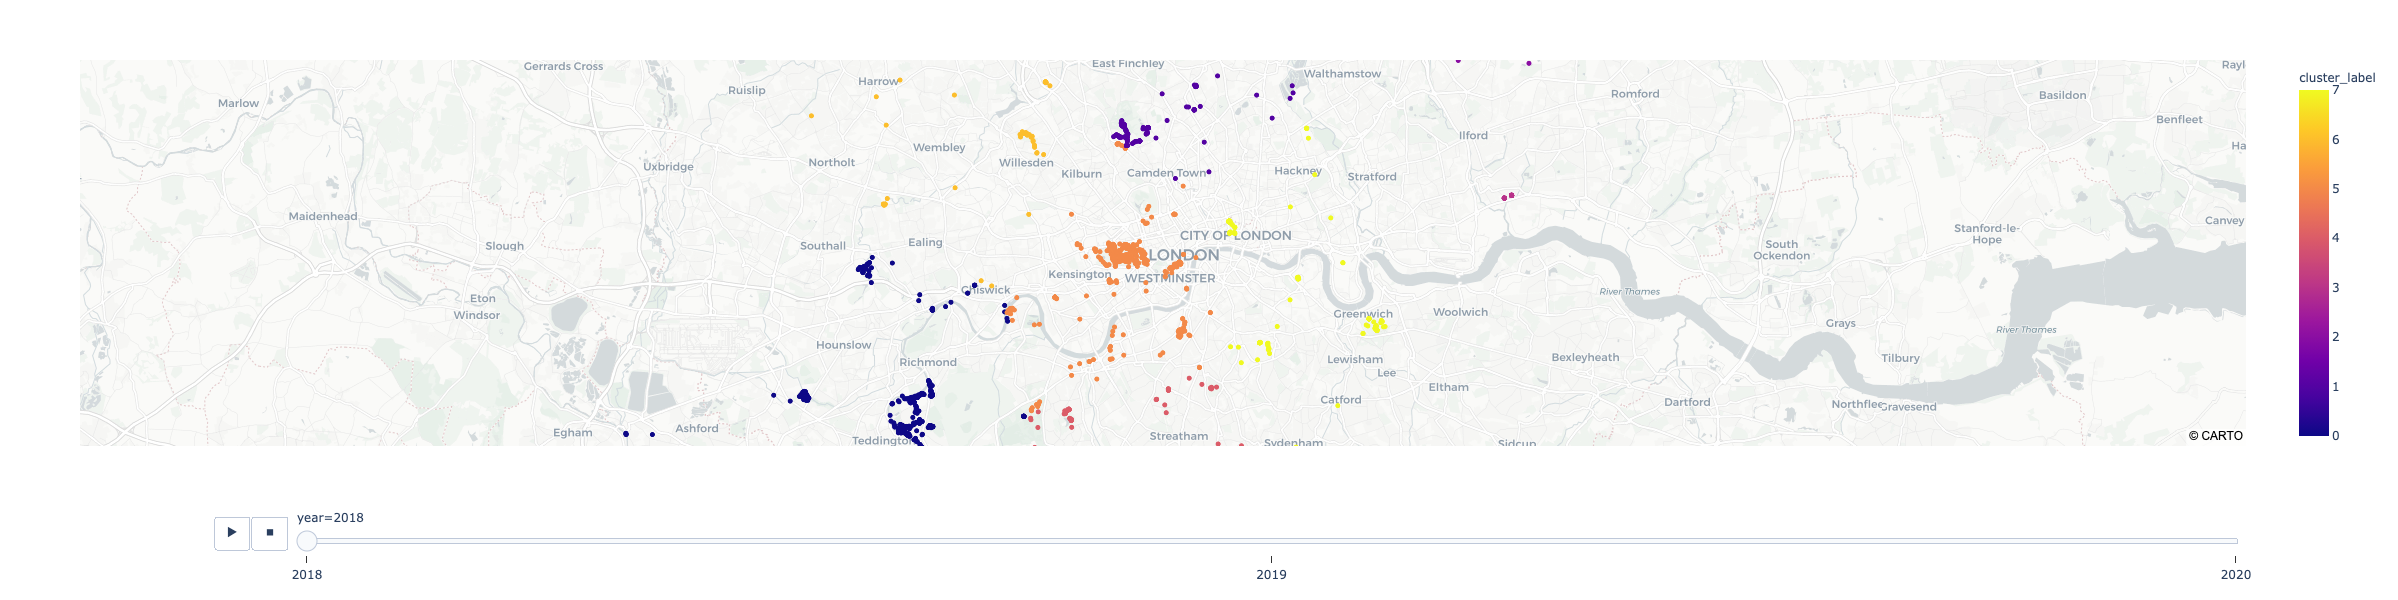

In [96]:
fig = px.scatter_mapbox(X, lat="latitude", lon="longitude", zoom=10, color='cluster_label', mapbox_style="carto-positron", animation_frame='year', height=600, hover_name='iconic_taxon_name')
fig.show()